##  <center>ITU / FIZ 437E </center>
##    <center> Statistical Learning from Data: Applications in Physics </center>
### **<center> Homework I Question 1 Solutions (KNN) </center>**

Gökay AKÇAY **090200147**

Burak Berk Cihan **090200161**

Ege Tan Tüzüner **090200131**

Umut Kaya **090190149**


## Question 1 (KNN Classifier)

### Used Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import MinMaxScaler

from scipy import __version__ as scipy_version
from scipy import stats
import math


In [2]:
!pip show pandas matplotlib numpy seaborn scikit-learn scipy | findstr "Name \| Version "


Name: pandas
Version: 1.4.2
Name: matplotlib
Version: 3.5.1
Name: numpy
Version: 1.22.3
Name: seaborn
Version: 0.11.2
Name: scikit-learn
Version: 1.0.2
Name: scipy
Version: 1.7.3


### Reading Data

In [3]:
df = pd.read_csv("htru2.csv")
df.head(5)

pmean       pstd     pskew     pkurt     dmean       dstd      dskew  \
0  140.562500  55.683782 -0.234571 -0.699648  3.199833  19.110426   7.975532   
1  102.507812  58.882430  0.465318 -0.515088  1.677258  14.860146  10.576487   
2  103.015625  39.341649  0.323328  1.051164  3.121237  21.744669   7.735822   
3  136.750000  57.178449 -0.068415 -0.636238  3.642977  20.959280   6.896499   
4   88.726562  40.672225  0.600866  1.123492  1.178930  11.468720  14.269573   

         dkur  ispulsar  
0   74.242225         0  
1  127.393580         0  
2   63.171909         0  
3   53.593661         0  
4  252.567306         0

### Null Check

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pmean     17898 non-null  float64
 1   pstd      17898 non-null  float64
 2   pskew     17898 non-null  float64
 3   pkurt     17898 non-null  float64
 4   dmean     17898 non-null  float64
 5   dstd      17898 non-null  float64
 6   dskew     17898 non-null  float64
 7   dkur      17898 non-null  float64
 8   ispulsar  17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


There are no null index.

### Normalization 

In [5]:
columns_to_normalize = ['pmean', 'pstd', 'pskew', 'pkurt', 'dmean', 'dstd', 'dskew', 'dkur']
df_normalized = df.copy()

scaler = MinMaxScaler()
df_normalized[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df_normalized

pmean      pstd     pskew     pkurt     dmean      dstd     dskew  \
0      0.721342  0.417687  0.165043  0.015627  0.013382  0.113681  0.294986   
1      0.517628  0.460908  0.235415  0.018268  0.006560  0.072524  0.364015   
2      0.520346  0.196868  0.221138  0.040677  0.013030  0.139188  0.288624   
3      0.700933  0.437884  0.181750  0.016534  0.015368  0.131583  0.266348   
4      0.443854  0.214847  0.249044  0.041712  0.004327  0.039684  0.462029   
...         ...       ...       ...       ...       ...       ...       ...   
17893  0.699218  0.473948  0.169741  0.015077  0.004855  0.046437  0.493364   
17894  0.624942  0.333936  0.201496  0.030260  0.072572  0.360761  0.161482   
17895  0.607712  0.475144  0.204652  0.015007  0.095069  0.498699  0.149653   
17896  0.581866  0.393617  0.208855  0.025283  0.007766  0.058209  0.348926   
17897  0.274351  0.824590  0.330038  0.026918  0.842789  0.555255  0.040918   

           dkur  ispulsar  
0      0.063890         0  
1      0.108443         0  
2      0.054610         0  
3      0.046581         0  
4      0.213369         0  
...         ...       ...  
17893  0.241336         0  
17894  0.008612         0  
17895  0.005509         0  
17896  0.114181         0  
17897  0.002855         0  

[17898 rows x 9 columns]

### Eda's & Plots

#### Before Normalization

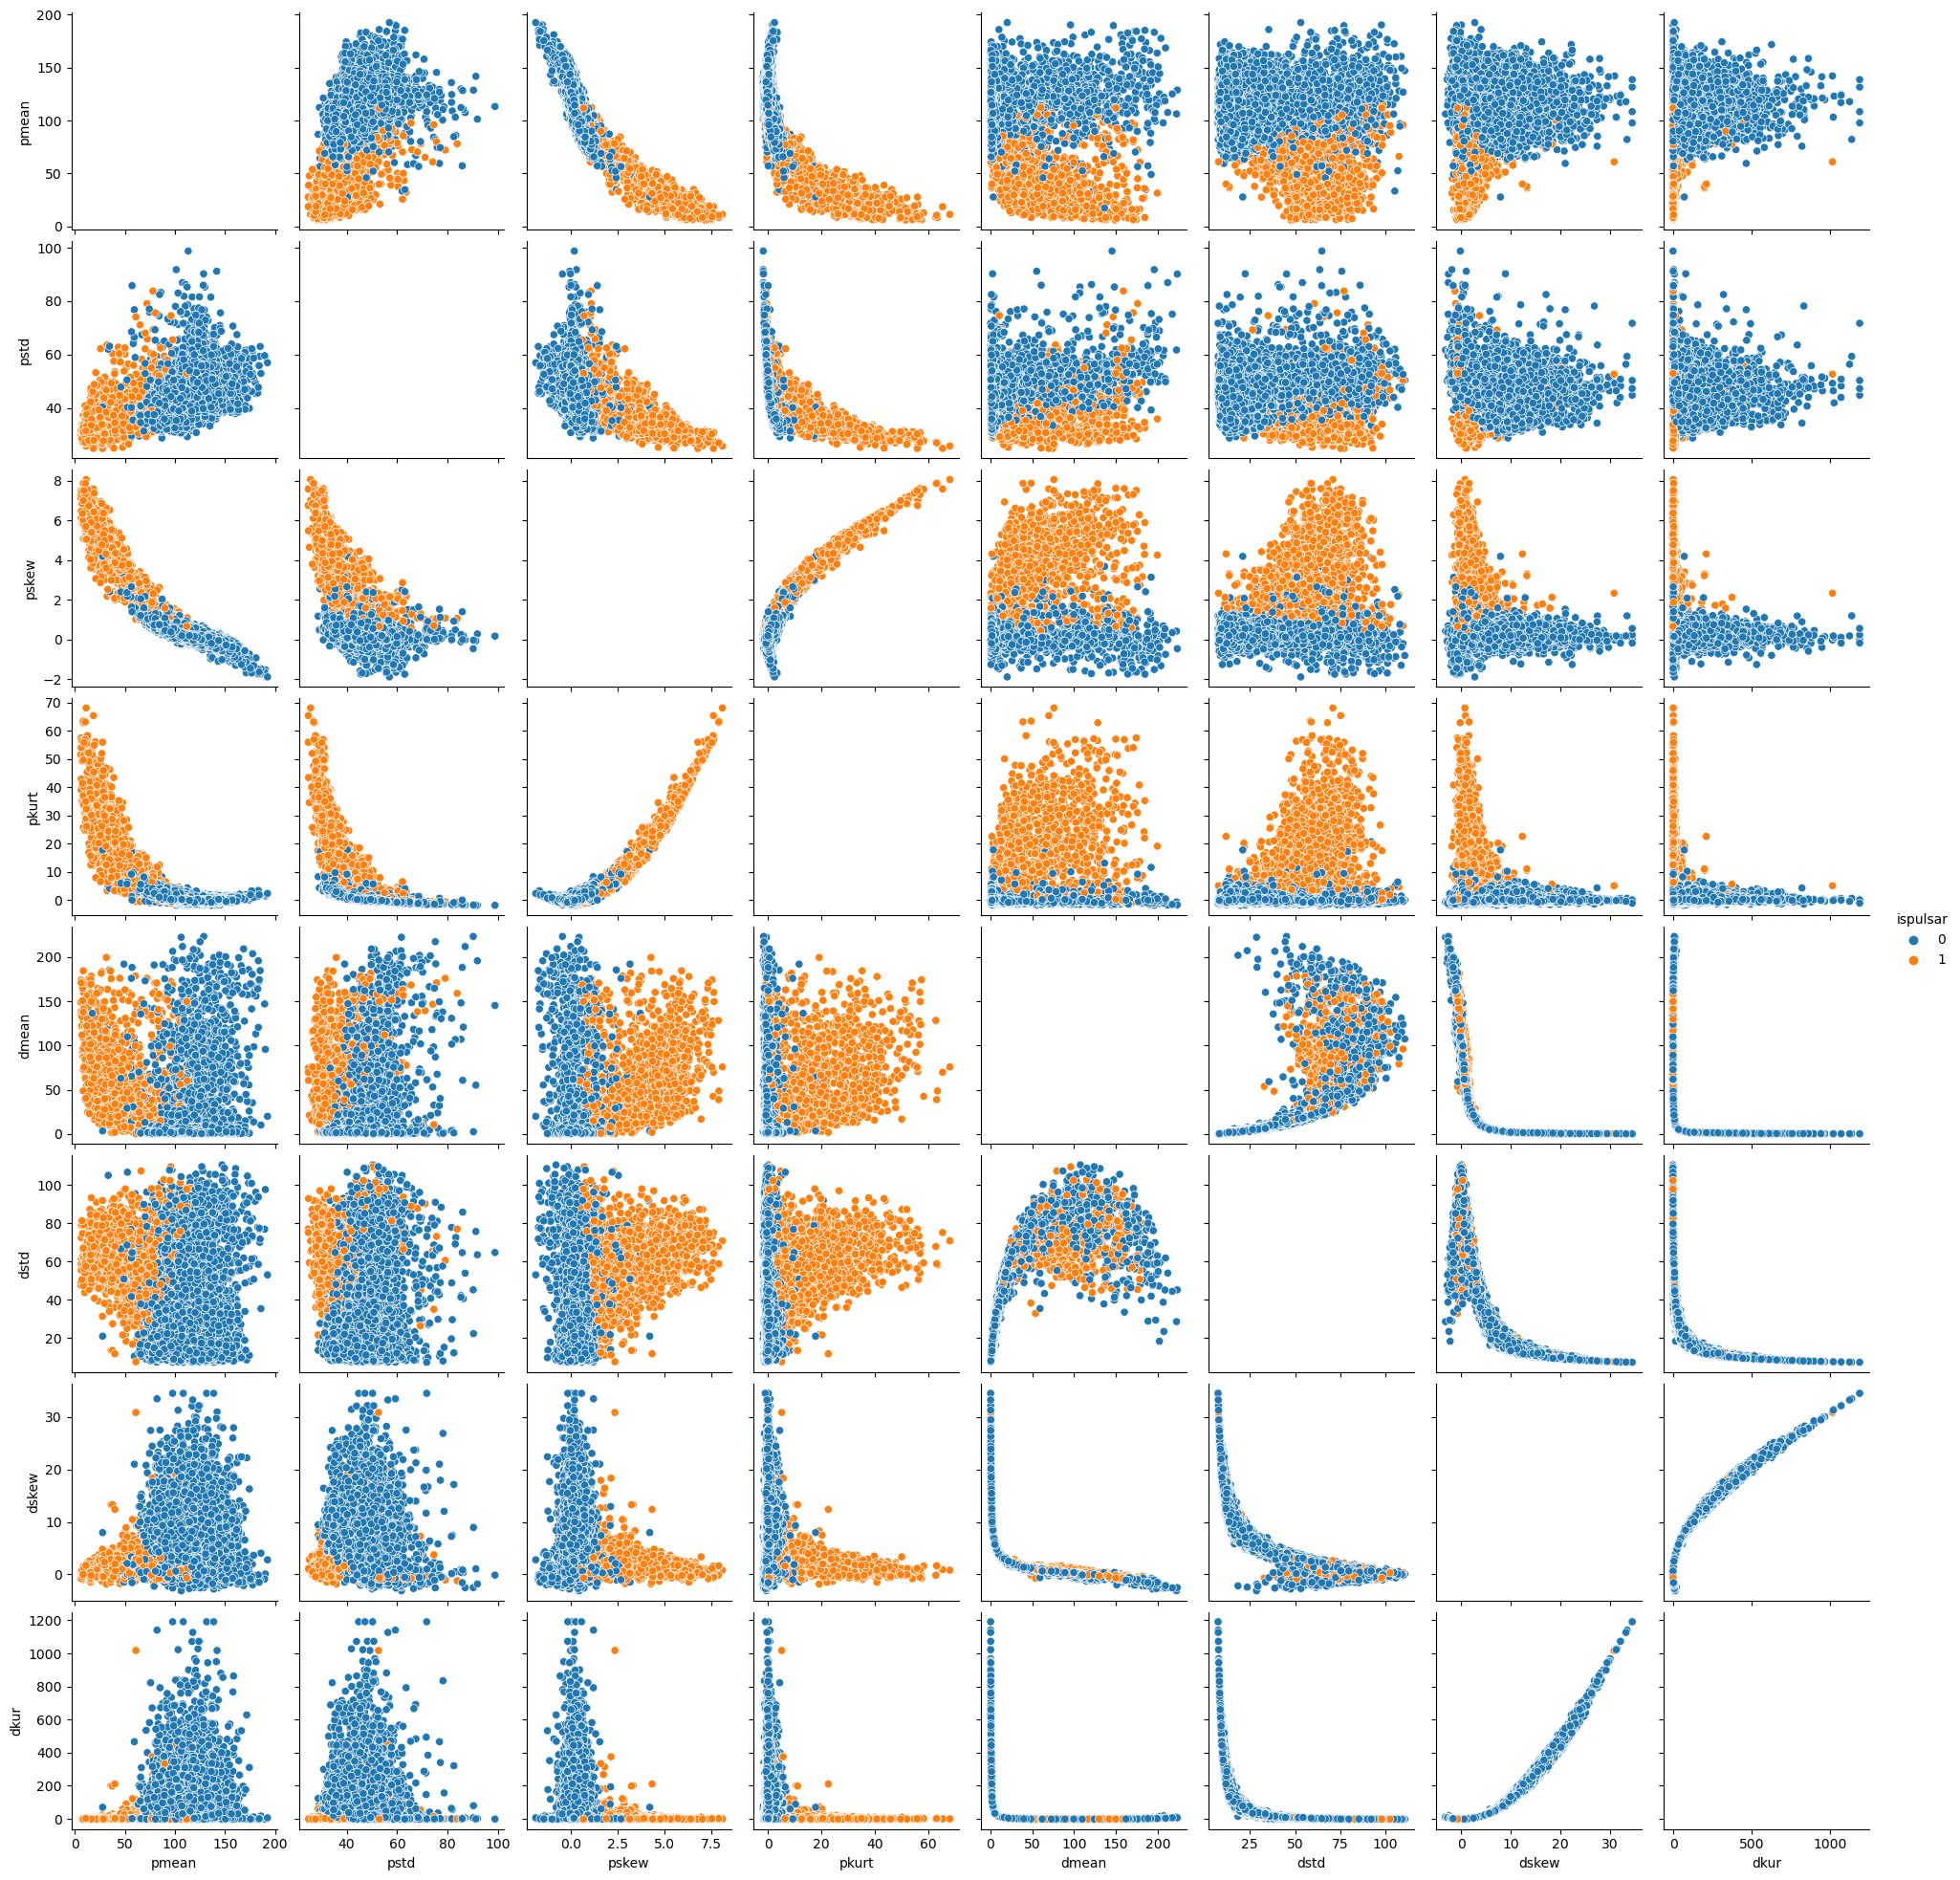

In [6]:
#General overview to data. This may take a time little bit.
sns.pairplot(data = df,hue="ispulsar",diag_kind = "scatter")

#### After Normalization

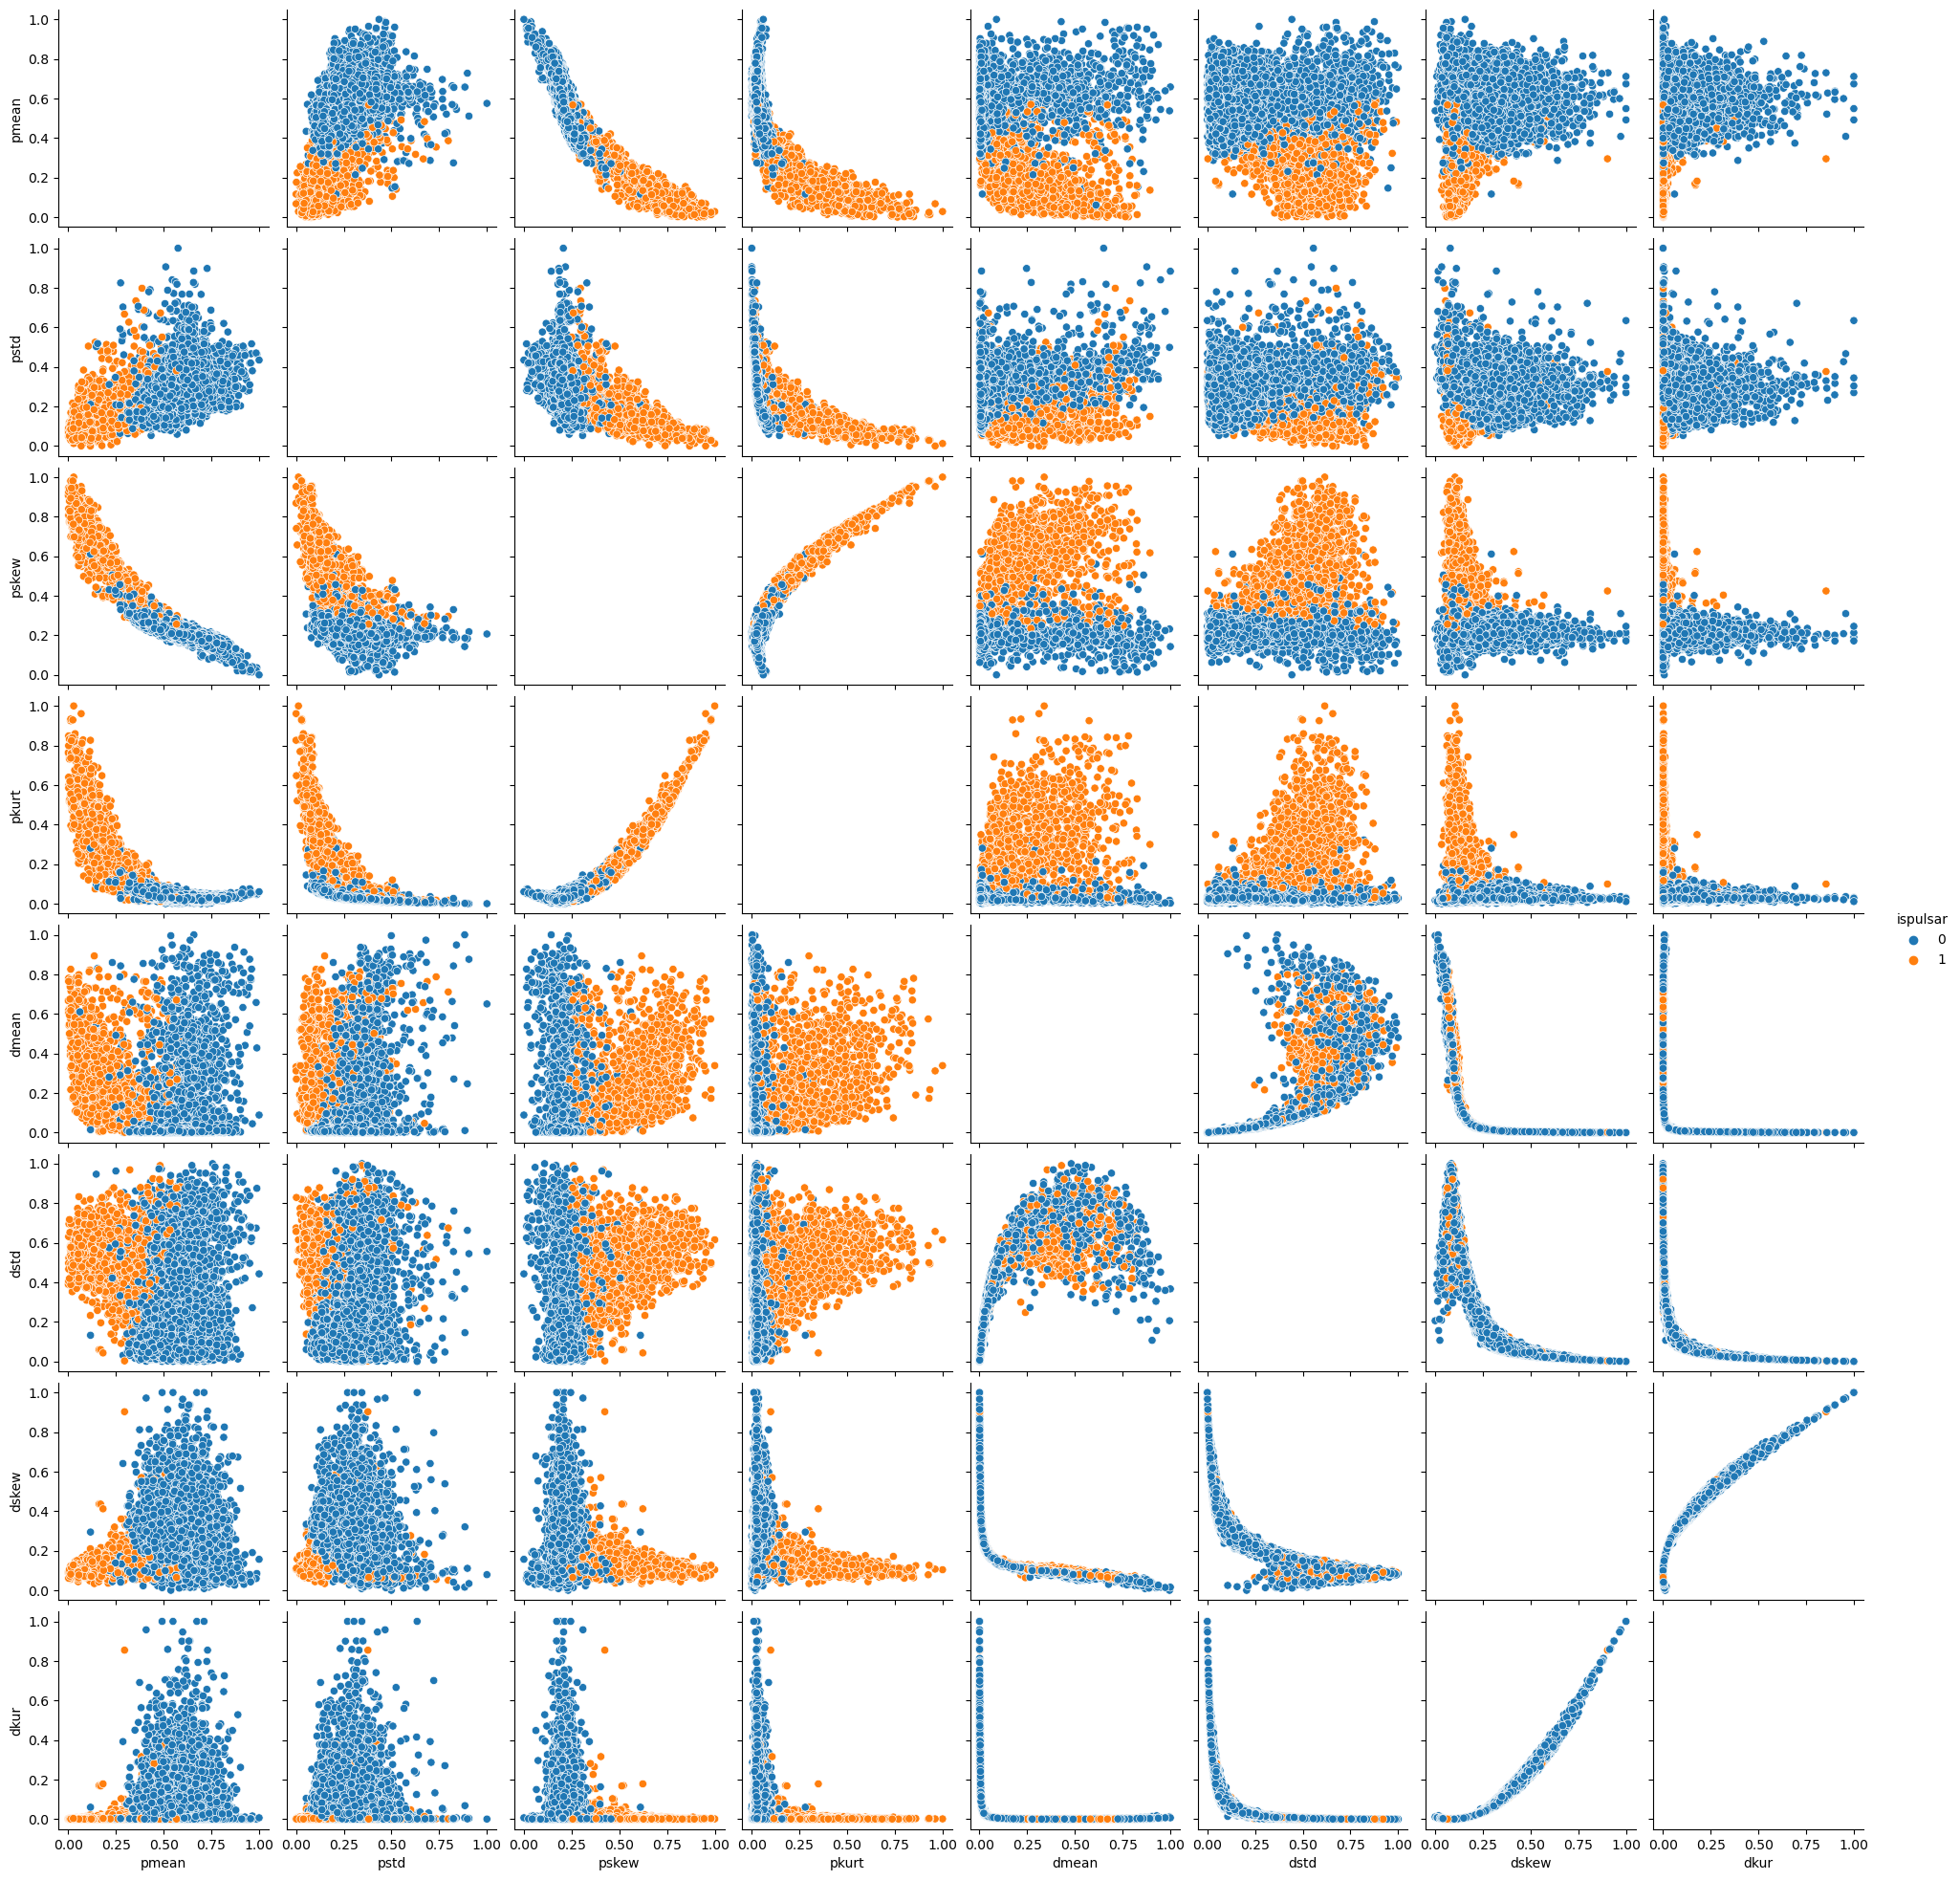

In [7]:
sns.pairplot(data = df_normalized,hue="ispulsar",diag_kind = "scatter")

As it seems, some of these pairplots are more suitable for classification. Like (p-kurtosis/p-mean) or (p-skew/p-mean) etc... 

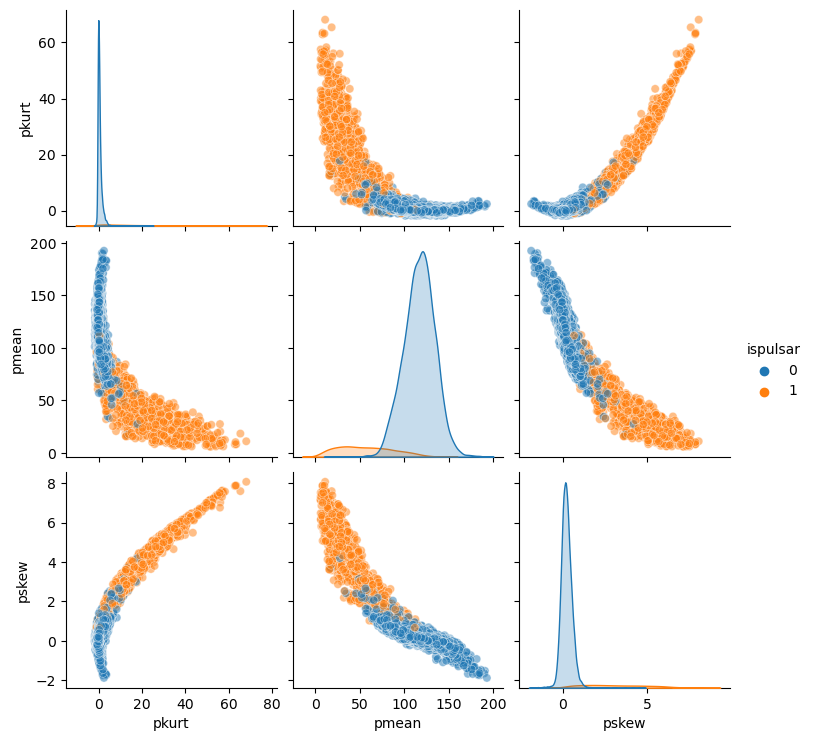

In [8]:
sns.pairplot(data = df, vars= ["pkurt","pmean","pskew"],hue="ispulsar",kind = "scatter", 
             plot_kws={'alpha':0.5})

Label distributions are much significant while using pkurt,pmean and pskew parameters. Later, these values can be used for parameter choices in our model.

### Model Implementation

### Knn & Metrics

In [9]:
# distance metric
def euclidean_distance(x1, x2):
    distance = np.sqrt(np.sum((np.array(x1)-np.array(x2))**2))
    return distance

def manhattan_distance(x1, x2):
    distance = np.sum(np.abs(np.array(x1)-np.array(x2)))
    return distance

def minkowski_distance(x1, x2, p=2):
    distance = (np.sum((np.array(x1)-np.array(x2))**p))**(1/p)
    return distance

In [10]:
class KNeighborsClassifier:
    # initiate
    def __init__(self, k=5,dist_type = "euclidean"):
        self.k = k
        self.dist_type = dist_type
        
    # fit function
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
  
    # predict function
    def predict(self, x):
        labels = []
        for value in x:
            if self.dist_type== "euclidean":
                distances = [minkowski_distance(value, X_train) for X_train in self.X_train]
            elif self.dist_type == "minkowski":
                distances = [euclidean_distance(value, X_train) for X_train in self.X_train]
            elif self.dist_type == "manhattan":
                distances = [manhattan_distance(value, X_train) for X_train in self.X_train]
                
            k_inds = np.argsort(distances)[:self.k]
            #print("k indices:", k_inds)
            classes_k = [self.y_train[i] for i in k_inds]
            mode = stats.mode(classes_k)
            labels.append(mode[0])
        return labels  

## Prediction

In [11]:
def evaluate_with_different_K(k_vals, X_train,X_test,y_train,y_test, _dist_type = "euclidean"):
    
    f1_k = []
    c_mtx_k = []
    precision_k = []
    recall_k = []
    accuracy_k = []
    for i in k_vals:
        
        neigh = KNeighborsClassifier(k=i,dist_type = _dist_type)
        neigh.fit(X_train,y_train)
        y_pred = neigh.predict(X_test)    
        
        f1 = f1_score(y_pred,y_test)
        c_mtx = confusion_matrix(y_pred,y_test)
        precision = precision_score(y_pred,y_test)
        recall = recall_score(y_pred,y_test)
        accuracy = accuracy_score(y_pred,y_test)
        
        f1_k.append((i,f1))
        c_mtx_k.append((i,c_mtx))
        precision_k.append((i,precision))
        recall_k.append((i,recall))
        accuracy_k.append((i,accuracy))
        
    f1_k = np.asarray(f1_k).reshape(-1,2)
    accuracy_k = np.asarray(accuracy_k).reshape(-1,2)
    precision_k = np.asarray(precision_k).reshape(-1,2)
    recall_k = np.asarray(recall_k).reshape(-1,2)
        
    return (f1_k,c_mtx_k,precision_k,recall_k,accuracy_k)
     

**Using the first 5500 row as a subsample data**

In [12]:
subsample_df = df_normalized.iloc[:5500,:]
x_sample = np.asarray(subsample_df.iloc[:,:8]).reshape(-1,8)
y_sample = np.asarray(subsample_df.iloc[:,-1]).reshape(-1)

In [13]:
X_train, X_test , y_train, y_test = train_test_split(x_sample,y_sample, test_size = 0.0909) # 0.0909 refers to 500 / 5500 ratio

As a default lets try only with Euclidiean distance and k = 3 and k = 5

In [14]:
k_f1_euc,k_cmtx_euc,k_recall_euc,k_precision_euc,k_accuracy_euc = evaluate_with_different_K([3,5],X_train,X_test,y_train,y_test)

In [15]:
print(f"Euclidean Distance (by K's) f1_scores: \n {k_f1_euc}  \n recall: \n {k_precision_euc} \n precision: \n {k_recall_euc}  \n accuracy: \n {k_accuracy_euc} \n Confusion Matrix: \n {k_cmtx_euc}" )

Euclidean Distance (by K's) f1_scores: 
 [[3.         0.92424242]
 [5.         0.92307692]]  
 recall: 
 [[3.         0.92424242]
 [5.         0.9375    ]] 
 precision: 
 [[3.         0.92424242]
 [5.         0.90909091]]  
 accuracy: 
 [[3.   0.98]
 [5.   0.98]] 
 Confusion Matrix: 
 [(3, array([[429,   5],
       [  5,  61]], dtype=int64)), (5, array([[430,   6],
       [  4,  60]], dtype=int64))]


[Text(0.5, 0, 'K-Nearest'), Text(0, 0.5, 'f1_score')]

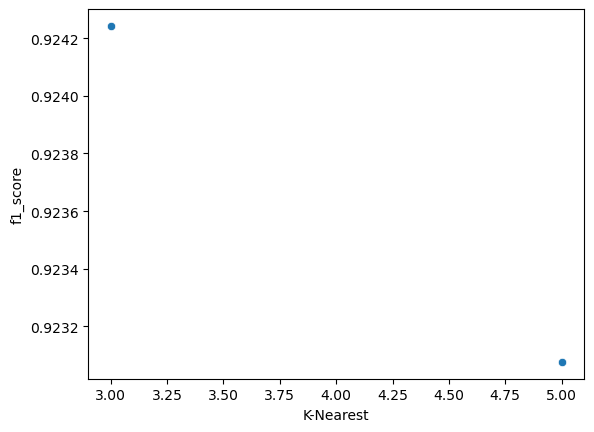

In [16]:
ax = sns.scatterplot(x = k_f1_euc[:,0],y = k_f1_euc[:,1])
ax.set(xlabel = 'K-Nearest',ylabel= 'f1_score')

### Changing Hyperparameters

In [17]:
train_labels = df.columns[:-1]
target_label = "ispulsar"

In [18]:
k_values = [3,5,7]
dist_types = ['euclidean','minkowski', 'manhattan']

iterables = [[dist_type for dist_type in dist_types],k_values]

mux = pd.MultiIndex.from_product(iterables, names=["dist type","k values"])
dist_and_ks = pd.DataFrame(index = mux,columns = ['f1_score','accuracy','precision','recall','confusion_mtx'])

dist_and_ks.head()

f1_score accuracy precision recall confusion_mtx
dist type k values                                                 
euclidean 3             NaN      NaN       NaN    NaN           NaN
          5             NaN      NaN       NaN    NaN           NaN
          7             NaN      NaN       NaN    NaN           NaN
minkowski 3             NaN      NaN       NaN    NaN           NaN
          5             NaN      NaN       NaN    NaN           NaN

As before, the Euclidean Distance was used while calculating the distances. What if other hyperparameters would be used like Minkowski or Manhattan distances?

In [19]:
for dist in dist_types:
    
    k_f1,k_cmtx,k_precision,k_recall,k_accuracy = evaluate_with_different_K(k_values,X_train,X_test,y_train,y_test,dist)
    
    #print(f"{dist} (by K's) f1_scores: \n {k_f1} \n confusion matrices: \n {k_cmtx}")
   
    for i in range (0,len(k_values)):
        dist_and_ks.loc[(dist,k_values[i]),'f1_score'] = k_f1[i,1]
        dist_and_ks.loc[(dist,k_values[i]),'confusion_mtx'] = np.asarray(k_cmtx[i][1]).astype("str")
        dist_and_ks.loc[(dist,k_values[i]),'accuracy'] = k_accuracy[i,1]
        dist_and_ks.loc[(dist,k_values[i]),'recall'] = k_recall[i,1]
        dist_and_ks.loc[(dist,k_values[i]),'precision'] = k_precision[i,1]

In [20]:
dist_and_ks

f1_score accuracy precision    recall        confusion_mtx
dist type k values                                                            
euclidean 3         0.924242     0.98  0.924242  0.924242  [[429, 5], [5, 61]]
          5         0.923077     0.98  0.909091    0.9375  [[430, 6], [4, 60]]
          7         0.914729    0.978  0.893939  0.936508  [[430, 7], [4, 59]]
minkowski 3         0.924242     0.98  0.924242  0.924242  [[429, 5], [5, 61]]
          5         0.923077     0.98  0.909091    0.9375  [[430, 6], [4, 60]]
          7         0.914729    0.978  0.893939  0.936508  [[430, 7], [4, 59]]
manhattan 3         0.917293    0.978  0.924242  0.910448  [[428, 5], [6, 61]]
          5         0.931298    0.982  0.924242  0.938462  [[430, 5], [4, 61]]
          7         0.916031    0.978  0.909091  0.923077  [[429, 6], [5, 60]]

#### k values vs f1 score by dist types

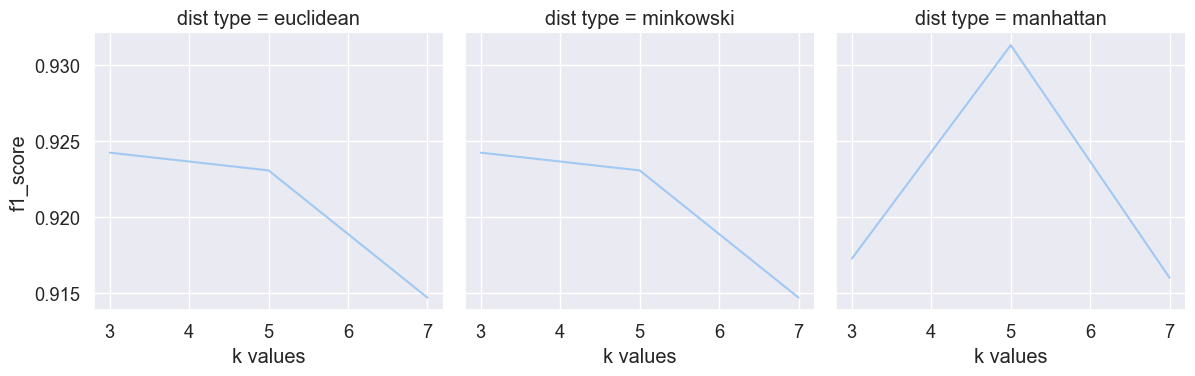

In [21]:
sns.set_theme(style="darkgrid", palette="pastel", font_scale=1.2)
g = sns.FacetGrid(data = dist_and_ks.reset_index(), col="dist type", col_wrap=4, height=4)
g.map(sns.lineplot,'k values','f1_score')

#### precision vs recall by dist types

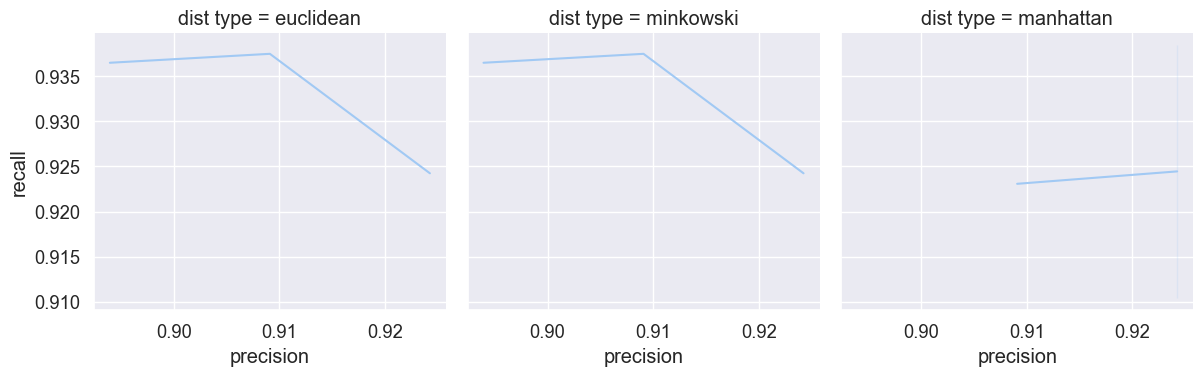

In [22]:
g = sns.FacetGrid(data = dist_and_ks.reset_index(), col="dist type", col_wrap=4, height=4)
g.map(sns.lineplot,'precision','recall')

## Cross Validation 

In [23]:
k_values = [1, 2, 3, 5, 10, 15, 20]

In [24]:
n_split_amount = 5
kf = KFold(n_splits=n_split_amount)

In [25]:
iterables = [[f'Model {i+1}' for i in range(n_split_amount)],k_values]

mux = pd.MultiIndex.from_product(iterables, names=["Model Name","k values"])

models_df = pd.DataFrame(index = mux,columns = ['f1_score','accuracy','precision','recall','confusion_mtx'])

I coded the part above for showing k value and metrics(like confusion matrix) for each model

In [26]:
models_df.head(5)

f1_score accuracy precision recall confusion_mtx
Model Name k values                                                 
Model 1    1             NaN      NaN       NaN    NaN           NaN
           2             NaN      NaN       NaN    NaN           NaN
           3             NaN      NaN       NaN    NaN           NaN
           5             NaN      NaN       NaN    NaN           NaN
           10            NaN      NaN       NaN    NaN           NaN

In [27]:
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    
    print(f"Fold {i}:")
    
    X_train_fold = X_train[train_index]
    X_test_fold = X_train[test_index]
    
    y_train_fold = y_train[train_index]
    y_test_fold =  y_train[test_index]
    
    f1_k_pairs = []
    c_mtx = []
    
    k_f1,k_cmtx,k_precision,k_recall,k_accuracy = evaluate_with_different_K(k_values,X_train_fold,X_test_fold,y_train_fold,y_test_fold,"euclidean")
       
    for k in range (0,len(k_values)):
        models_df.loc[(f"Model {i+1}",k_values[k]),'f1_score'] = k_f1[k,1]
        models_df.loc[(f"Model {i+1}",k_values[k]),'confusion_mtx'] = np.asarray(k_cmtx[k][1]).astype("str")
        models_df.loc[(f"Model {i+1}",k_values[k]),'accuracy'] = k_accuracy[k,1]
        models_df.loc[(f"Model {i+1}",k_values[k]),'recall'] = k_recall[k,1]
        models_df.loc[(f"Model {i+1}",k_values[k]),'precision'] = k_precision[k,1]
      
    

Fold 0:
manhattan (by K's) f1_scores: 
 [[ 1.          0.86394558]
 [ 2.          0.88808664]
 [ 3.          0.90526316]
 [ 5.          0.91549296]
 [10.          0.9       ]
 [15.          0.89285714]
 [20.          0.9       ]] 
 confusion matrices: 
 [(1, array([[833,  24],
       [ 16, 127]], dtype=int64)), (2, array([[846,  28],
       [  3, 123]], dtype=int64)), (3, array([[844,  22],
       [  5, 129]], dtype=int64)), (5, array([[846,  21],
       [  3, 130]], dtype=int64)), (10, array([[846,  25],
       [  3, 126]], dtype=int64)), (15, array([[845,  26],
       [  4, 125]], dtype=int64)), (20, array([[846,  25],
       [  3, 126]], dtype=int64))]
Fold 1:
manhattan (by K's) f1_scores: 
 [[ 1.          0.85090909]
 [ 2.          0.86821705]
 [ 3.          0.89298893]
 [ 5.          0.8880597 ]
 [10.          0.88549618]
 [15.          0.88301887]
 [20.          0.88636364]] 
 confusion matrices: 
 [(1, array([[842,  23],
       [ 18, 117]], dtype=int64)), (2, array([[854,  28],


Each metrics are seperated for each Model and each k values

In [28]:
models_df

f1_score accuracy precision    recall  \
Model Name k values                                          
Model 1    1         0.863946     0.96   0.84106  0.888112   
           2         0.888087    0.969   0.81457   0.97619   
           3         0.905263    0.973  0.854305  0.962687   
           5         0.915493    0.976  0.860927  0.977444   
           10             0.9    0.972  0.834437  0.976744   
           15        0.892857     0.97  0.827815  0.968992   
           20             0.9    0.972  0.834437  0.976744   
Model 2    1         0.850909    0.959  0.835714  0.866667   
           2         0.868217    0.966       0.8  0.949153   
           3         0.892989    0.971  0.864286  0.923664   
           5          0.88806     0.97      0.85  0.929688   
           10        0.885496     0.97  0.828571   0.95082   
           15        0.883019    0.969  0.835714     0.936   
           20        0.886364     0.97  0.835714  0.943548   
Model 3    1         0.878049    0.965  0.887324  0.868966   
           2         0.874525    0.967  0.809859  0.950413   
           3          0.89781    0.972  0.866197  0.931818   
           5         0.899628    0.973  0.852113  0.952756   
           10        0.882129    0.969  0.816901  0.958678   
           15        0.886364     0.97  0.823944  0.959016   
           20        0.877863    0.968  0.809859  0.958333   
Model 4    1         0.905405    0.972  0.899329  0.911565   
           2         0.899281    0.972  0.838926  0.968992   
           3         0.927336    0.979  0.899329  0.957143   
           5          0.93007     0.98  0.892617  0.970803   
           10        0.896057    0.971  0.838926  0.961538   
           15        0.903226    0.973  0.845638  0.969231   
           20        0.895307    0.971  0.832215   0.96875   
Model 5    1         0.834483    0.952  0.801325  0.870504   
           2         0.859259    0.962  0.768212   0.97479   
           3         0.880866    0.967  0.807947  0.968254   
           5         0.884892    0.968   0.81457  0.968504   
           10        0.863469    0.963  0.774834     0.975   
           15        0.875912    0.966  0.794702   0.97561   
           20        0.863469    0.963  0.774834     0.975   

                              confusion_mtx  
Model Name k values                          
Model 1    1         [[833, 24], [16, 127]]  
           2          [[846, 28], [3, 123]]  
           3          [[844, 22], [5, 129]]  
           5          [[846, 21], [3, 130]]  
           10         [[846, 25], [3, 126]]  
           15         [[845, 26], [4, 125]]  
           20         [[846, 25], [3, 126]]  
Model 2    1         [[842, 23], [18, 117]]  
           2          [[854, 28], [6, 112]]  
           3         [[850, 19], [10, 121]]  
           5          [[851, 21], [9, 119]]  
           10         [[854, 24], [6, 116]]  
           15         [[852, 23], [8, 117]]  
           20         [[853, 23], [7, 117]]  
Model 3    1         [[839, 16], [19, 126]]  
           2          [[852, 27], [6, 115]]  
           3          [[849, 19], [9, 123]]  
           5          [[852, 21], [6, 121]]  
           10         [[853, 26], [5, 116]]  
           15         [[853, 25], [5, 117]]  
           20         [[853, 27], [5, 115]]  
Model 4    1         [[838, 15], [13, 134]]  
           2          [[847, 24], [4, 125]]  
           3          [[845, 15], [6, 134]]  
           5          [[847, 16], [4, 133]]  
           10         [[846, 24], [5, 125]]  
           15         [[847, 23], [4, 126]]  
           20         [[847, 25], [4, 124]]  
Model 5    1         [[831, 30], [18, 121]]  
           2          [[846, 35], [3, 116]]  
           3          [[845, 29], [4, 122]]  
           5          [[845, 28], [4, 123]]  
           10         [[846, 34], [3, 117]]  
           15         [[846, 31], [3, 120]]  
           20         [[846, 34], [3, 117]]

#### COMPARING F1 RESULTS

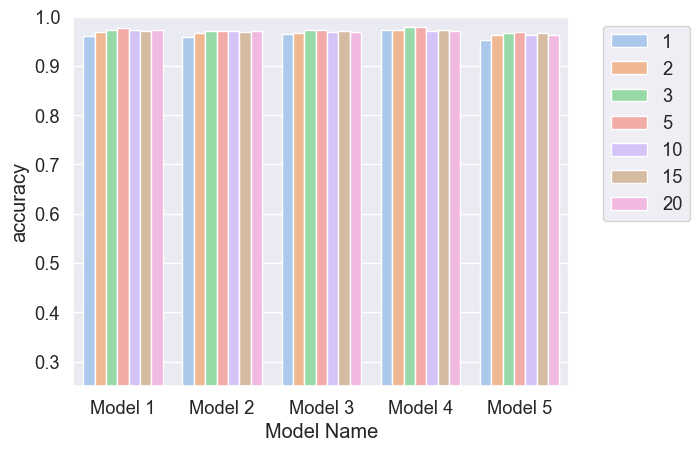

In [29]:
ax = sns.barplot(data = models_df.reset_index(), x = 'Model Name' ,y = 'accuracy', hue = 'k values')
ax.set_ylim(0.25, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Model vs Accuracy

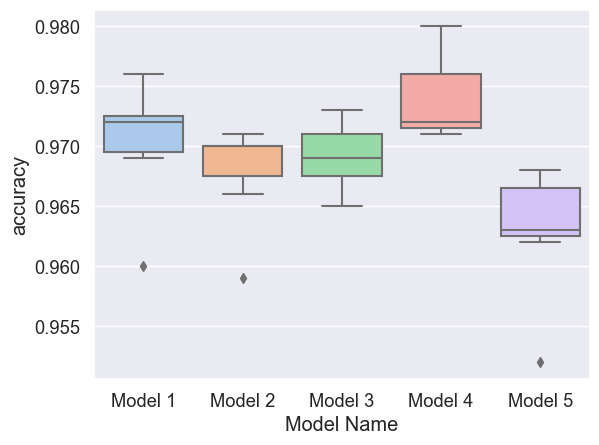

In [30]:
ax = sns.boxplot(data = models_df.reset_index(), x = 'Model Name' ,y = 'accuracy')

**Model 4** is the best with highest accuracy score, it also has the higher mean

#### K value vs Accuracy

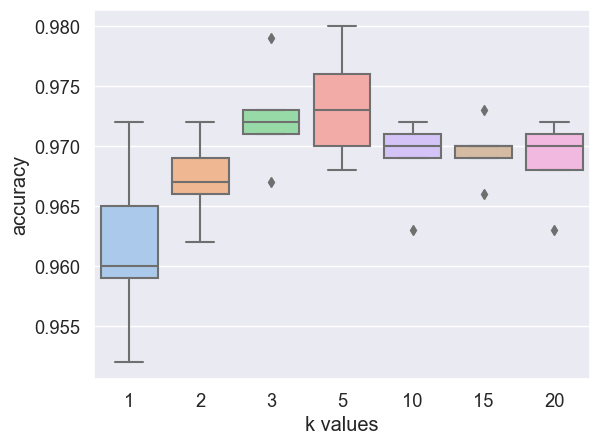

In [31]:
ax = sns.boxplot(data = models_df.reset_index(), x = 'k values' ,y = 'accuracy')

**k = 5** looks good with high accuracy score

#### F1 Score, Accuracy, Precision and Recall metrics for each k values

Metrics by Model Name as a table view

In [62]:
models_df.groupby(['Model Name','k values'])[['accuracy','f1_score', 'precision', 'recall']].agg(['mean', 'max'])

accuracy         f1_score           precision            \
                        mean    max      mean       max      mean       max   
Model Name k values                                                           
Model 1    1           0.960  0.960  0.863946  0.863946  0.841060  0.841060   
           2           0.969  0.969  0.888087  0.888087  0.814570  0.814570   
           3           0.973  0.973  0.905263  0.905263  0.854305  0.854305   
           5           0.976  0.976  0.915493  0.915493  0.860927  0.860927   
           10          0.972  0.972  0.900000  0.900000  0.834437  0.834437   
           15          0.970  0.970  0.892857  0.892857  0.827815  0.827815   
           20          0.972  0.972  0.900000  0.900000  0.834437  0.834437   
Model 2    1           0.959  0.959  0.850909  0.850909  0.835714  0.835714   
           2           0.966  0.966  0.868217  0.868217  0.800000  0.800000   
           3           0.971  0.971  0.892989  0.892989  0.864286  0.864286   
           5           0.970  0.970  0.888060  0.888060  0.850000  0.850000   
           10          0.970  0.970  0.885496  0.885496  0.828571  0.828571   
           15          0.969  0.969  0.883019  0.883019  0.835714  0.835714   
           20          0.970  0.970  0.886364  0.886364  0.835714  0.835714   
Model 3    1           0.965  0.965  0.878049  0.878049  0.887324  0.887324   
           2           0.967  0.967  0.874525  0.874525  0.809859  0.809859   
           3           0.972  0.972  0.897810  0.897810  0.866197  0.866197   
           5           0.973  0.973  0.899628  0.899628  0.852113  0.852113   
           10          0.969  0.969  0.882129  0.882129  0.816901  0.816901   
           15          0.970  0.970  0.886364  0.886364  0.823944  0.823944   
           20          0.968  0.968  0.877863  0.877863  0.809859  0.809859   
Model 4    1           0.972  0.972  0.905405  0.905405  0.899329  0.899329   
           2           0.972  0.972  0.899281  0.899281  0.838926  0.838926   
           3           0.979  0.979  0.927336  0.927336  0.899329  0.899329   
           5           0.980  0.980  0.930070  0.930070  0.892617  0.892617   
           10          0.971  0.971  0.896057  0.896057  0.838926  0.838926   
           15          0.973  0.973  0.903226  0.903226  0.845638  0.845638   
           20          0.971  0.971  0.895307  0.895307  0.832215  0.832215   
Model 5    1           0.952  0.952  0.834483  0.834483  0.801325  0.801325   
           2           0.962  0.962  0.859259  0.859259  0.768212  0.768212   
           3           0.967  0.967  0.880866  0.880866  0.807947  0.807947   
           5           0.968  0.968  0.884892  0.884892  0.814570  0.814570   
           10          0.963  0.963  0.863469  0.863469  0.774834  0.774834   
           15          0.966  0.966  0.875912  0.875912  0.794702  0.794702   
           20          0.963  0.963  0.863469  0.863469  0.774834  0.774834   

                       recall            
                         mean       max  
Model Name k values                      
Model 1    1         0.888112  0.888112  
           2         0.976190  0.976190  
           3         0.962687  0.962687  
           5         0.977444  0.977444  
           10        0.976744  0.976744  
           15        0.968992  0.968992  
           20        0.976744  0.976744  
Model 2    1         0.866667  0.866667  
           2         0.949153  0.949153  
           3         0.923664  0.923664  
           5         0.929688  0.929688  
           10        0.950820  0.950820  
           15        0.936000  0.936000  
           20        0.943548  0.943548  
Model 3    1         0.868966  0.868966  
           2         0.950413  0.950413  
           3         0.931818  0.931818  
           5         0.952756  0.952756  
           10        0.958678  0.958678  
           15        0.959016  0.959016  
           20        0.958333  0.958333  
Model 4  

#### F1 Score, Accuracy, Precision and Recall metrics for each k values

Metrics by K values as a table view

In [61]:
models_df.groupby(['k values'])[['f1_score','accuracy', 'precision', 'recall']].agg(['mean', 'std', 'max'])

f1_score                     accuracy                  precision  \
              mean       std       max     mean       std    max      mean   
k values                                                                     
1         0.866558  0.027026  0.905405   0.9616  0.007436  0.972  0.852950   
2         0.877874  0.015918  0.899281   0.9672  0.003701  0.972  0.806313   
3         0.900853  0.017258  0.927336   0.9724  0.004336  0.979  0.858413   
5         0.903629  0.019035  0.930070   0.9734  0.004775  0.980  0.854045   
10        0.885430  0.014304  0.900000   0.9690  0.003536  0.972  0.818734   
15        0.888276  0.010352  0.903226   0.9696  0.002510  0.973  0.825562   
20        0.884600  0.014550  0.900000   0.9688  0.003564  0.972  0.817412   

                                recall                      
               std       max      mean       std       max  
k values                                                    
1         0.040113  0.899329  0.881162  0.019007  0.911565  
2         0.025671  0.838926  0.963908  0.013181  0.976190  
3         0.032912  0.899329  0.948713  0.019755  0.968254  
5         0.027900  0.892617  0.959839  0.019134  0.977444  
10        0.025892  0.838926  0.964556  0.011068  0.976744  
15        0.019145  0.845638  0.961770  0.015581  0.975610  
20        0.026047  0.835714  0.964475  0.013741  0.976744

#### Precision vs Recall by K values

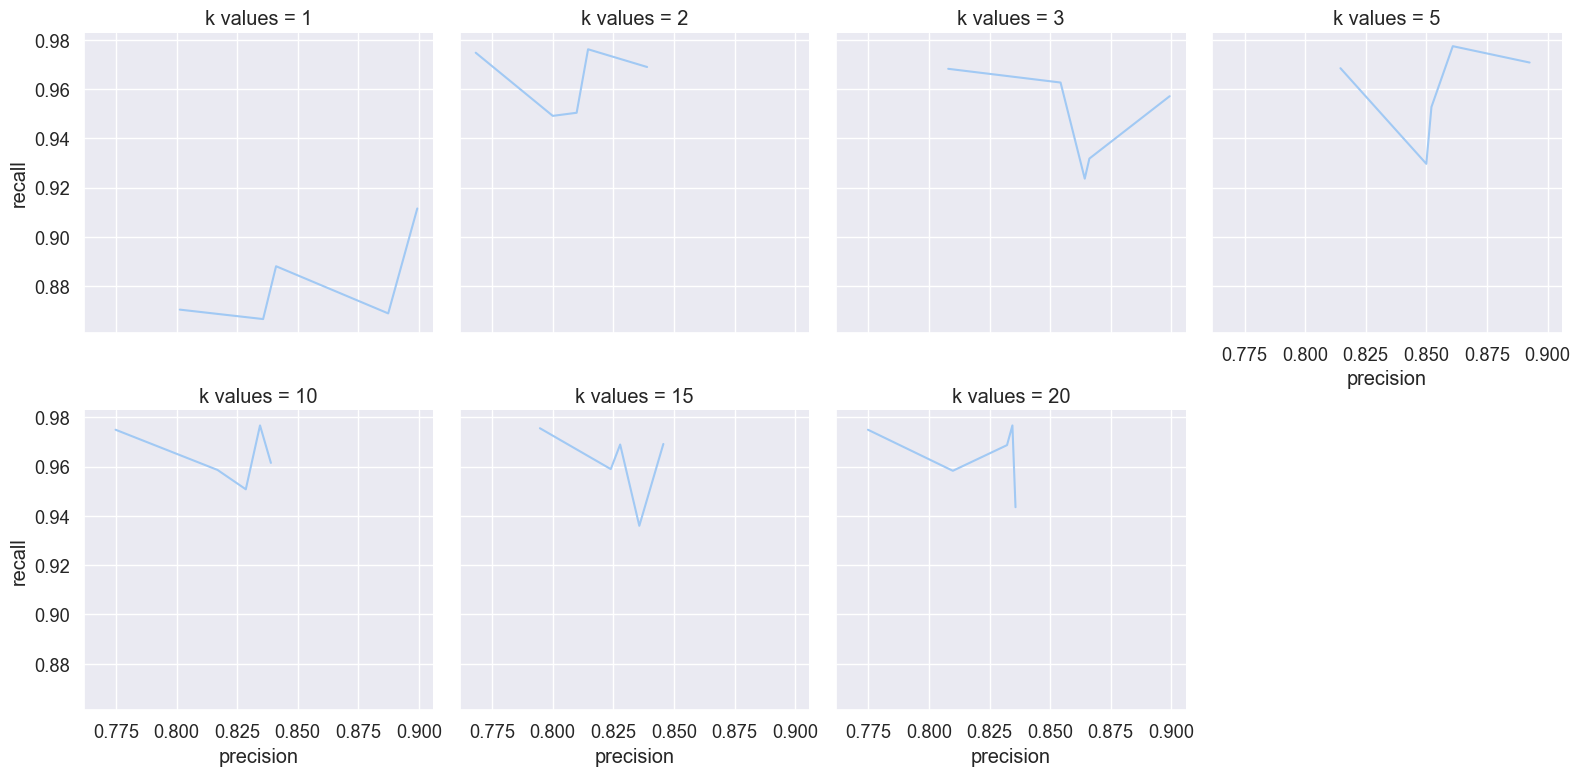

In [56]:
g = sns.FacetGrid(data = precision_vs_recall.reset_index(), col="k values", col_wrap=4, height=4)
g.map(sns.lineplot,'precision','recall')

Summary: Model 4 with k = 5 may be the best choice to classify our Pulsars.